In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.optimize import minimize

In [2]:
data = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')

In [3]:
%%time

price_df_list = []
for i in tqdm(range(120)):
    price_data = data.iloc[:,3*i:3*i+2].copy()
    price_data.dropna(inplace=True)
    price_data.iloc[:,0] = pd.to_datetime(price_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    price_data.rename(columns = {price_data.columns[0] : 'Date', price_data.columns[1]: price_data.columns[0]}, inplace = True)
    price_data.set_index('Date', inplace = True)
    price_df_list.append(price_data)

agg_price_data = price_df_list[0]
for df in tqdm(price_df_list[1:]):
    agg_price_data = agg_price_data.join(df, how='outer', sort = True)

agg_price_data = agg_price_data[(agg_price_data.index >= '31/12/2016') & (agg_price_data.index <= '31/12/2020')]

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:00<00:00, 695.91it/s]

CPU times: total: 109 ms
Wall time: 355 ms


In [4]:
for ticker in tqdm(agg_price_data.columns):
    series = agg_price_data[ticker]
    first = series.first_valid_index()
    last = series.last_valid_index()
    series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
    agg_price_data[ticker][(agg_price_data[ticker].index >= first) & (agg_price_data[ticker].index <= last)] = series_real

  0%|          | 0/120 [00:00<?, ?it/s]C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\1015039934.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\1015039934.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\1015039934.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_real = series[(series.index >= first) & (series.index <= last)].fillna(method = 'bfill')
C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\1015039934.py:5: 

In [5]:
for ticker in tqdm(agg_price_data.columns):
    if agg_price_data[ticker].isnull().values.any():
        print(ticker)
        nulls = agg_price_data[ticker].isnull()
        print(nulls[nulls == True].index)

100%|██████████| 120/120 [00:00<00:00, 14109.17it/s]

ALD FP Equity
DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2017-06-01', '2017-06-02', '2017-06-05', '2017-06-06',
               '2017-06-07', '2017-06-08', '2017-06-09', '2017-06-12',
               '2017-06-13', '2017-06-14'],
              dtype='datetime64[ns]', name='Date', length=115, freq=None)
GTO NA Equity
DatetimeIndex(['2019-05-29', '2019-05-30', '2019-05-31', '2019-06-03',
               '2019-06-04', '2019-06-05', '2019-06-06', '2019-06-07',
               '2019-06-10', '2019-06-11',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=410, freq=None)
ING FP Equity
DatetimeIndex(['2020-11-09', '

In [6]:
returns = agg_price_data.pct_change().dropna() # set returns to 0 when the stock disappears

C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\136000960.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = agg_price_data.pct_change().dropna() # set returns to 0 when the stock disappears


In [7]:
df_mkt_cap_list = []
for i in tqdm(range(120)):
    mkt_cap_data = data.iloc[:,[3*i,3*i+2]].copy()
    mkt_cap_data.dropna(inplace = True)
    mkt_cap_data.iloc[:,0] = pd.to_datetime(mkt_cap_data.iloc[:,0], unit= 'D', origin= '1899-12-30')
    mkt_cap_data.rename(columns = {mkt_cap_data.columns[0] : 'Date', mkt_cap_data.columns[1]: mkt_cap_data.columns[0]}, inplace = True)
    mkt_cap_data.set_index('Date', inplace = True)
    df_mkt_cap_list.append(mkt_cap_data)

agg_mkt_cap_data = df_mkt_cap_list[0]
for df in tqdm(df_mkt_cap_list[1:]):
    agg_mkt_cap_data = agg_mkt_cap_data.join(df, how='outer', sort = True)

100%|██████████| 119/119 [00:00<00:00, 645.37it/s]


In [8]:
for ticker in tqdm(agg_mkt_cap_data.columns):
    if agg_mkt_cap_data[ticker].isnull().values.any():
        print(ticker)
        nulls = agg_mkt_cap_data[ticker].isnull()
        print(nulls[nulls == True].index)

100%|██████████| 120/120 [00:00<00:00, 4783.24it/s]

RUI FP Equity
DatetimeIndex(['2013-02-06', '2013-02-11'], dtype='datetime64[ns]', name='Date', freq=None)
ALD FP Equity
DatetimeIndex(['2010-12-31', '2011-01-03', '2011-01-04', '2011-01-05',
               '2011-01-06', '2011-01-07', '2011-01-10', '2011-01-11',
               '2011-01-12', '2011-01-13',
               ...
               '2017-06-02', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09', '2017-06-12', '2017-06-13',
               '2017-06-14', '2017-06-15'],
              dtype='datetime64[ns]', name='Date', length=1653, freq=None)
DSY FP Equity
DatetimeIndex(['2013-01-04', '2013-01-09'], dtype='datetime64[ns]', name='Date', freq=None)
CAP FP Equity
DatetimeIndex(['2013-03-08', '2013-03-11'], dtype='datetime64[ns]', name='Date', freq=None)
GNFT FP Equity
DatetimeIndex(['2013-01-04', '2013-01-09', '2013-02-06', '2013-02-11'], dtype='datetime64[ns]', name='Date', freq=None)
AC FP Equity
DatetimeIndex(['2013-04-05', '2013-04-08'], dtype='date

In [9]:
agg_mkt_cap_data.fillna(value = 0.0, inplace = True)

In [10]:
agg_mkt_cap_data.isnull().values.any()

False

In [11]:
top10comp=agg_mkt_cap_data.loc['2018-12-31'].sort_values(ascending=False).head(10)
top10=list(top10comp.index.values) 

In [12]:
mkt_2017_2018=agg_mkt_cap_data.loc['2017-01-01':'2018-12-31'][top10]

In [13]:
mkt_2019=agg_mkt_cap_data.loc['2019-01-01':'2019-12-31'][top10]

In [14]:
price_2019=agg_price_data['2019-01-01':'2019-12-31'][top10]
returns_2019 = price_2019.pct_change()

In [15]:
n=len(top10)

In [16]:
class Strategy:

    def __init__(self, name, returns):
        self.name = name
        self.returns = returns
        self.pnl = np.c_[np.array([100.]), 100.*np.cumprod(1.+returns.to_numpy()).reshape(1,-1)].flatten()

    def volatility(self):
        return np.std(self.returns)*np.sqrt(252)

    def sharpe_ratio(self):
        return np.mean(self.returns)*np.sqrt(252)/np.std(self.returns)

    def max_dd(self):
        return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(self.pnl)))/self.pnl)

    def max_dd_2(self):
        return np.max(1. - self.pnl/np.maximum.accumulate(self.pnl))

    def illustrate(self, colour):
        plt.plot(pd.to_datetime(self.returns.index), self.pnl[1:], 'b', label = self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%
                                                          (self.volatility(), self.sharpe_ratio(), self.max_dd()), color = colour)
        plt.xlabel('Time')
        plt.ylabel('PnL')
        plt.legend()
        plt.tick_params(axis='x', rotation = 45)
        plt.title(f'PnL of the strategy {self.name}')
        plt.grid(axis = 'x', linestyle = '--')
        plt.tight_layout()

In [17]:
class EWP(Strategy):
    def __init__(self, name, returns):
        self.name = name
        self.returns = returns
        returns_EWP = np.sum(returns * (1 / len(returns.columns)), axis=1)
        super().__init__(self.name, returns_EWP)

In [18]:

Por1 = EWP('equally-weighted portfolio', returns_2019)

C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\50781593.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(pd.to_datetime(self.returns.index), self.pnl[1:], 'b', label = self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%


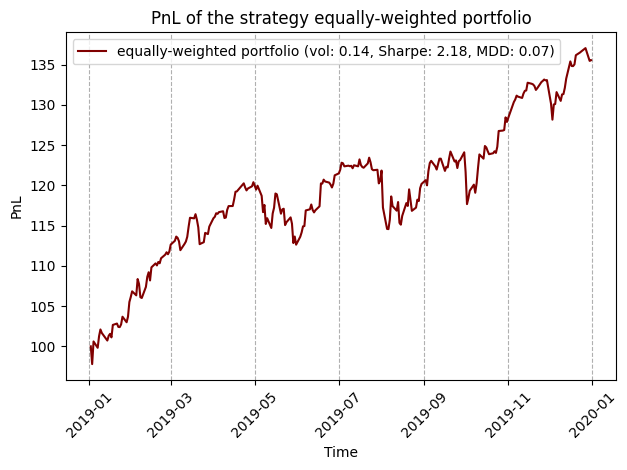

In [19]:
Por1.illustrate('Maroon')


In [20]:
price_2017_2018=agg_price_data['2017-01-01':'2018-12-31'][top10]
returns_2017_2018 = price_2017_2018.pct_change()

In [21]:
var_cov_mat = returns_2017_2018.cov()

In [26]:
class Markowitz(Strategy):
    
    def __init__(self, name, returns, cov):

        self.name = name
        self.returns = returns
        self.cov = cov
        w = self.minimum_variance()
        returns_Mark = np.sum(returns.apply(lambda x: x * w, axis = 1), axis = 1)
        super().__init__(self.name, returns_Mark)

    def minimum_variance(self):

        emp_var = self.cov

        def find_port_variance(weights):
            
            port_var = np.sqrt(np.dot(weights.T, np.dot(emp_var, weights)) * 250)
            return port_var

        def weight_cons(weights):
            return np.sum(weights) - 1


        bounds_lim = [(0, 1) for x in range(len(self.returns.columns))]
        init = [1/len(self.returns.columns) for i in range(len(self.returns.columns))]
        constraint = {'type': 'eq', 'fun': weight_cons}

        optimal = minimize(fun=find_port_variance,
                        x0=init,
                        bounds=bounds_lim,
                        constraints=constraint,
                        method='SLSQP'
                        )
        

        return list(optimal['x'])

In [27]:
Por2 = Markowitz('equally-weighted portfolio', returns_2019, var_cov_mat)

C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\50781593.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(pd.to_datetime(self.returns.index), self.pnl[1:], 'b', label = self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%
C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\50781593.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(pd.to_datetime(self.returns.index), self.pnl[1:], 'b', label = self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%
C:\Users\kacpe\AppData\Local\Temp\ipykernel_11416\50781593.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


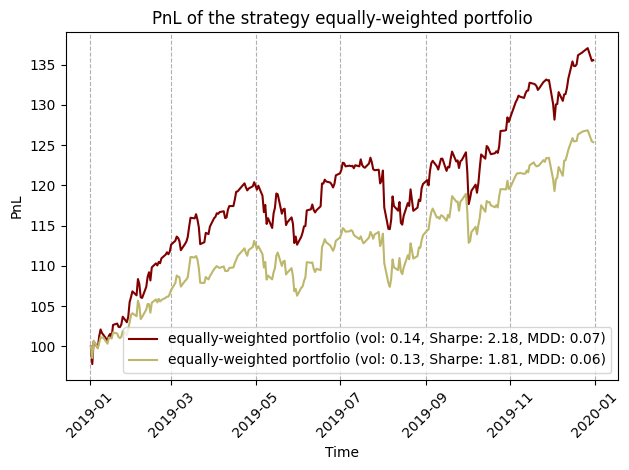

In [31]:
Por1.illustrate('maroon')
Por2.illustrate('darkkhaki')